# Pneumonia Detection Project - Data Preparation

## Pneumonia Detection from Chest X-Ray Images  
### Data Preparation & Exploratory Analysis

This notebook focuses on preparing the chest X-ray dataset for our pneumonia detection project in CS 171.  
We will:
- Load the **Chest X-Ray Images (Pneumonia)** dataset from local folders.
- Apply image transformations such as resizing, normalization, and augmentation.
- Build PyTorch `DataLoader` objects for training, validation, and testing.
- Visually inspect sample images and class distributions.

Authors: **Aye Nyein Kyaw** and **Isiah Ketton**  
Course: **CS 171 – Machine Learning**


- Import PyTorch and `torchvision` utilities.
- Define the paths to the training, validation, and test directories.
- Set up image transformations for preprocessing.

In [1]:
# Import libraries
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Dataset Description

We use the **Chest X-Ray Images (Pneumonia)** dataset by Paul Mooney, originally published on Kaggle and sourced from the Guangzhou Women and Children’s Medical Center.

The dataset has three main splits:
- `train/` – used to train the model
- `val/` – used to tune hyperparameters
- `test/` – used to evaluate final performance

Each split contains two classes:
- `NORMAL`
- `PNEUMONIA`

In this project, the dataset is stored locally in the following structure:

```text
data/
  chest_xray/
    train/
      NORMAL/
      PNEUMONIA/
    val/
      NORMAL/
      PNEUMONIA/
    test/
      NORMAL/
      PNEUMONIA/


In [2]:
# Define data directories (adjust to your path)
train_dir = "data/chest_xray/train"
val_dir = "data/chest_xray/val"
test_dir = "data/chest_xray/test"

## Image Transformations and DataLoaders

For deep learning models, we typically:
- **Resize** images to a fixed size (e.g., 150 × 150 pixels).
- **Convert** images to tensors.
- **Normalize** pixel values so they are on a consistent scale.

Here we define a base set of transforms:
- `transforms.Resize((150, 150))` to standardize image size.
- `transforms.ToTensor()` to convert images to PyTorch tensors.
- `transforms.Normalize(mean=[0.5], std=[0.5])` to normalize pixel values around 0.

We then create `ImageFolder` datasets and `DataLoader` objects for:
- `train_data`
- `val_data`
- `test_data`

These will be used later in the model training notebook.


In [3]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
# Load training data (this will work once data is downloaded locally)
train_data = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Load validation data
val_data = datasets.ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Load testing data
test_data = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print summary
print(f"Number of training images: {len(train_data)}")
print(f"Classes: {train_data.classes}")
print(f"Number of training images: {len(val_data)}")
print(f"Classes: {val_data.classes}")
print(f"Number of training images: {len(test_data)}")
print(f"Classes: {test_data.classes}")

Number of training images: 5216
Classes: ['NORMAL', 'PNEUMONIA']


## Visualizing Sample Training Images

To sanity-check that:
- The dataset is loaded correctly,
- Labels are mapped correctly to `NORMAL` and `PNEUMONIA`,
- Transforms are applied as expected,

we display a small batch of sample images from the training set along with their class labels.
This helps us confirm that the data pipeline is working before moving on to model training.


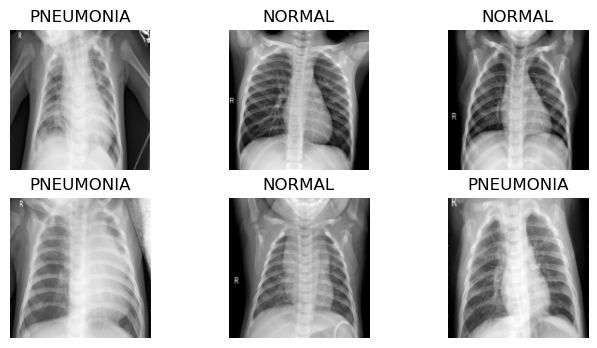

In [5]:
# Preview a few images
images, labels = next(iter(train_loader))
plt.figure(figsize=(8, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i][0], cmap="gray")
    plt.title(train_data.classes[labels[i]])
    plt.axis("off")
plt.show()